<a href="https://colab.research.google.com/github/mezlet/PPI-Inhibitors/blob/main/code/GNN_based_pipeline_Training_for_Predicting_small_molecule_inhibition_of_protein_complexes_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set the Runtime->Change Runtime Type to GPU**

# Protein 3d structure assessment with graph neural networks

In [ ]:
!fusermount -u /content/drive
!rm -rf /content/drive
%cd /content


In [ ]:
#!rm -r Data
!rm -r PPI-Inhibitors
!git clone https://github.com/adibayaseen/PPI-Inhibitors
#!pip install py3Dmol

In [ ]:
!pip install --upgrade pip setuptools wheel
!pip install rdkit biopython==1.81 torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 torch-geometric==2.5.3 tqdm==4.66.2 pandas==2.1.4 numpy==1.26.4 scikit-learn==1.3.2 matplotlib==3.8.3 seaborn==0.13.2 networkx==3.2.1 gdown


In [ ]:
%cd PPI-Inhibitors
!mkdir -p Data

%cd Data
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/01ad4975fb9133825b1bf9e71b64fcdaaa5e4d8b/Data/2p2iComplexPairs.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/01ad4975fb9133825b1bf9e71b64fcdaaa5e4d8b/Data/2p2iInhibitorsSMILES.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/2d6bd03422602ec19147870c487e64018b52660f/Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt
!wget -q https://github.com/adibayaseen/PPI-Inhibitors/raw/b1e45884f61f792399abad2e4492f48083ab1093/Data/BindersWithComplexname.csv
%cd ..

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive'

# Make folders
!mkdir -p GNN-PPI-Inhibitor
!gdown --id 1goeDiPZSKT1Xx3j00eNG9xlqYkLLv1gW -O GNN-PPI-Inhibitor/ProteinData_dict.pickle
!gdown --id 1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE -O GNN-PPI-Inhibitor/DBD5_ProteinData_dict.pickle

In [36]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  9 16:43:15 2024

@author: u1876024
"""


import torch
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

class BalancedDataset(Dataset):
    """
    A custom dataset class that creates a balanced dataset from imbalanced data.
    This dataset calculates sample weights inversely proportional to class frequencies,
    which can be used with a WeightedRandomSampler to achieve balanced batches.

    NOTE: As it involves stochastic sampling, there is a chance that a few training examples are actually never selected.

    Attributes:
        data (array-like): The input data. Can be a list, NumPy array, or PyTorch tensor.
        labels (array-like): The labels corresponding to the data. Should be a 1D array-like object.
        sample_weights (torch.Tensor): Weights for each sample, inversely proportional to class frequencies.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__(idx): Returns the sample and its corresponding label at the given index.
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

        # Count the number of examples in each class
        class_counts = np.bincount(self.labels)
        # Assign weight inversely proportional to class frequency
        weights = 1. / torch.tensor(class_counts, dtype=torch.float)
        # Create a weight list for each sample
        self.sample_weights = weights[labels]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def create_balanced_loader(data, labels, batch_size=32):
    """
    Creates a DataLoader with balanced batches for a given dataset.
    This function is useful for training models on imbalanced datasets.

    Args:
        data (array-like): The input data. Can be a list, NumPy array, or PyTorch tensor.
        labels (array-like): The labels corresponding to the data. Should be a 1D array-like object.
        batch_size (int, optional): The size of each batch. Default is 32.

    Returns:
        DataLoader: A PyTorch DataLoader that yields balanced batches.

    Usage Example:
        >>> data = [features1, features2, ...]  # Replace with your data features
        >>> labels = [label1, label2, ...]     # Replace with your data labels
        >>> balanced_loader = create_balanced_loader(data, labels, batch_size=32)
        >>> for batch_data, batch_labels in balanced_loader:
        >>>     # Train your model using the balanced batches
    """
    dataset = BalancedDataset(data, labels)
    # WeightedRandomSampler will take care of the balancing
    sampler = WeightedRandomSampler(weights=dataset.sample_weights, num_samples=len(dataset.sample_weights), replacement=True)

    loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return loader


class BinaryBalancedSampler(Sampler):
    """
    A PyTorch Sampler that returns batches with an equal number of positive and negative examples.
    The sampler oversamples from the minority class to balance the majority class, ensuring that
    each batch contains 50% positive and 50% negative examples.

    NOTE: It leads to more examples in single iteration through the data loader than in one epoch

    Attributes:
        class_vector (list or numpy array): class labels.
        batch_size (int): The size of each batch.
        n_splits (int): The number of batches/splits in the dataset.
        equivalent_epochs (float): The number of times the sampler goes over the minority class
                                   in one complete iteration of the DataLoader.

    Methods:
        gen_sample_array: Yields indices for each batch ensuring class balance.
        __iter__: Returns an iterator over batch indices.
        __len__: Returns the number of batches in the sampler.
    """
    def __init__(self, class_vector, batch_size = 10):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        """
        self.batch_size = batch_size
        self.class_vector = class_vector
        YY = np.array(self.class_vector)
        U, C = np.unique(YY, return_counts=True)
        M = U[np.argmax(C)]        #find majority class
        Midx = np.nonzero(YY==M)[0] #indices of majority class
        midx = np.nonzero(YY!=M)[0] #indices of minority class
        midx_ = np.random.choice(midx,size=len(Midx))     #oversample minority indices so they are equal to majority ones
        self.YY = np.array(list(YY[Midx])+list(YY[midx_]))
        self.idx = np.array(list(Midx)+list(midx_))
        self.n_splits = int(np.ceil(len(self.idx)/self.batch_size))
        self.equivalent_epochs = len(self.idx)/len(self.class_vector)
        print('Equivalent epochs in one iteration of data loader',self.equivalent_epochs)

    def gen_sample_array(self):
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits= self.n_splits,shuffle=True)
        for tridx,ttidx in skf.split(self.idx,self.YY):
            yield np.array(self.idx[ttidx])

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return self.n_splits

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

if __name__=='__main__':

    E = [(str(p_i), str(-1*c_i)) for p_i, c_i in zip(range(100), range(100))]  # Replace with your data
    Y = np.random.randint(0, 2, size=100)  # Replace with your labels
    batch_size = 10

    dataset = CustomDataset(E, Y)
    batch_sampler = BinaryBalancedSampler(Y, batch_size)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    for batch in data_loader:
        print(batch)

    # Example usage of create_balanced_loader
    balanced_loader = create_balanced_loader(E, Y, batch_size)

    # Iterate over the DataLoader
    L = []
    for (pid,cid),label in balanced_loader:
        # Process your batches
        L.extend(pid)
    print(L)


Equivalent epochs in one iteration of data loader 1.12
[[('3', '14', '51', '80', '97', '43', '56', '92', '7', '50'), ('-3', '-14', '-51', '-80', '-97', '-43', '-56', '-92', '-7', '-50')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('9', '11', '20', '35', '39', '92', '79', '7', '63', '43'), ('-9', '-11', '-20', '-35', '-39', '-92', '-79', '-7', '-63', '-43')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('4', '6', '19', '47', '58', '76', '10', '28', '92', '72'), ('-4', '-6', '-19', '-47', '-58', '-76', '-10', '-28', '-92', '-72')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('5', '18', '33', '34', '78', '43', '93', '67', '25', '92'), ('-5', '-18', '-33', '-34', '-78', '-43', '-93', '-67', '-25', '-92')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])]
[[('2', '21', '37', '55', '83', '50', '36', '8', '85'), ('-2', '-21', '-37', '-55', '-83', '-50', '-36', '-8', '-85')], tensor([0, 0, 0, 0, 0, 1, 1, 1, 1])]
[[('29', '52', '68', '95', '96', '24', '90', '50', '17'), ('-29', '-52', '-68', '-95', '-96', 

CUDA is available. Number of GPUs: 1
GPU 0: Tesla T4


100%|██████████| 15695/15695 [00:00<00:00, 863214.50it/s]


Equivalent epochs in one iteration of data loader 1.8249820678348192
test complex  2XA0


  6%|▌         | 1/18 [00:10<02:56, 10.38s/it]

LOADED BEST AUCROC 0.4511138613861386 AUCPR 0.003200520324837369
AUCROC 0.4511138613861386 AUCPR 0.003200520324837369 best aucroc 0.4511138613861386



 11%|█         | 2/18 [00:18<02:28,  9.29s/it]

LOADED BEST AUCROC 0.4946369636963696 AUCPR 0.003545592027154804
AUCROC 0.4946369636963696 AUCPR 0.003545592027154804 best aucroc 0.4946369636963696



 28%|██▊       | 5/18 [00:46<02:01,  9.37s/it]

LOADED BEST AUCROC 0.5228960396039604 AUCPR 0.017370387019267068
AUCROC 0.5228960396039604 AUCPR 0.017370387019267068 best aucroc 0.5228960396039604



 33%|███▎      | 6/18 [00:56<01:51,  9.30s/it]

LOADED BEST AUCROC 0.5781765676567655 AUCPR 0.015795951746411286
AUCROC 0.5781765676567655 AUCPR 0.015795951746411286 best aucroc 0.5781765676567655



 39%|███▉      | 7/18 [01:04<01:38,  8.99s/it]

LOADED BEST AUCROC 0.6099422442244224 AUCPR 0.013645583655771117
AUCROC 0.6099422442244224 AUCPR 0.013645583655771117 best aucroc 0.6099422442244224



 50%|█████     | 9/18 [01:23<01:22,  9.21s/it]

LOADED BEST AUCROC 0.6171617161716172 AUCPR 0.009026239174326937
AUCROC 0.6171617161716172 AUCPR 0.009026239174326937 best aucroc 0.6171617161716172



 56%|█████▌    | 10/18 [01:32<01:13,  9.17s/it]

LOADED BEST AUCROC 0.6375825082508252 AUCPR 0.008799638692233377
AUCROC 0.6375825082508252 AUCPR 0.008799638692233377 best aucroc 0.6375825082508252



 61%|██████    | 11/18 [01:40<01:03,  9.04s/it]

LOADED BEST AUCROC 0.6619224422442244 AUCPR 0.009365739983697417
AUCROC 0.6619224422442244 AUCPR 0.009365739983697417 best aucroc 0.6619224422442244



 67%|██████▋   | 12/18 [01:49<00:53,  8.85s/it]

LOADED BEST AUCROC 0.674092409240924 AUCPR 0.008841833781125345
AUCROC 0.674092409240924 AUCPR 0.008841833781125345 best aucroc 0.674092409240924



 72%|███████▏  | 13/18 [01:58<00:45,  9.06s/it]

LOADED BEST AUCROC 0.6837871287128712 AUCPR 0.010827403969844364
AUCROC 0.6837871287128712 AUCPR 0.010827403969844364 best aucroc 0.6837871287128712



100%|██████████| 5/5 [13:41<00:00, 164.28s/it]


OUTSIDE LOOP AUC of Best
Complex name 2XA0 AUCROC 0.6837871287128712 AUCPR 0.010827403969844364
Equivalent epochs in one iteration of data loader 1.8322724057795292
test complex  3WN7


  6%|▌         | 1/18 [00:12<03:27, 12.22s/it]

LOADED BEST AUCROC 0.909598043710836 AUCPR 0.1288495784206541
AUCROC 0.909598043710836 AUCPR 0.1288495784206541 best aucroc 0.909598043710836



 11%|█         | 2/18 [00:24<03:17, 12.33s/it]

LOADED BEST AUCROC 0.9227418615314076 AUCPR 0.1334428896476332
AUCROC 0.9227418615314076 AUCPR 0.1334428896476332 best aucroc 0.9227418615314076



 17%|█▋        | 3/18 [00:35<02:57, 11.85s/it]

LOADED BEST AUCROC 0.9367262723521321 AUCPR 0.1572678709194018
AUCROC 0.9367262723521321 AUCPR 0.1572678709194018 best aucroc 0.9367262723521321



 28%|██▊       | 5/18 [00:57<02:26, 11.25s/it]

LOADED BEST AUCROC 0.9375668653522848 AUCPR 0.20412832833778716
AUCROC 0.9375668653522848 AUCPR 0.20412832833778716 best aucroc 0.9375668653522848



100%|██████████| 5/5 [15:21<00:00, 184.22s/it]


OUTSIDE LOOP AUC of Best
Complex name 3WN7 AUCROC 0.9375668653522848 AUCPR 0.20412832833778716
Equivalent epochs in one iteration of data loader 1.8699573793240163
test complex  3UVW


  5%|▌         | 1/19 [00:21<06:23, 21.28s/it]

LOADED BEST AUCROC 0.8110138645010244 AUCPR 0.36750355702737314
AUCROC 0.8110138645010244 AUCPR 0.36750355702737314 best aucroc 0.8110138645010244



 11%|█         | 2/19 [00:41<05:56, 20.94s/it]

LOADED BEST AUCROC 0.821707181006731 AUCPR 0.38046600045447415
AUCROC 0.821707181006731 AUCPR 0.38046600045447415 best aucroc 0.821707181006731



 16%|█▌        | 3/19 [01:04<05:43, 21.47s/it]

LOADED BEST AUCROC 0.8282690408252853 AUCPR 0.39244919931358463
AUCROC 0.8282690408252853 AUCPR 0.39244919931358463 best aucroc 0.8282690408252853



 21%|██        | 4/19 [01:25<05:22, 21.49s/it]

LOADED BEST AUCROC 0.831737452443664 AUCPR 0.39893930358120394
AUCROC 0.831737452443664 AUCPR 0.39893930358120394 best aucroc 0.831737452443664



 26%|██▋       | 5/19 [01:47<05:03, 21.66s/it]

LOADED BEST AUCROC 0.8327548836698858 AUCPR 0.40447541386433833
AUCROC 0.8327548836698858 AUCPR 0.40447541386433833 best aucroc 0.8327548836698858



 37%|███▋      | 7/19 [02:23<03:58, 19.90s/it]

LOADED BEST AUCROC 0.838196425958443 AUCPR 0.4375744903509667
AUCROC 0.838196425958443 AUCPR 0.4375744903509667 best aucroc 0.838196425958443



 42%|████▏     | 8/19 [02:45<03:45, 20.52s/it]

LOADED BEST AUCROC 0.8398746158911325 AUCPR 0.4539160024258388
AUCROC 0.8398746158911325 AUCPR 0.4539160024258388 best aucroc 0.8398746158911325



100%|██████████| 5/5 [23:55<00:00, 287.18s/it]


OUTSIDE LOOP AUC of Best
Complex name 3UVW AUCROC 0.8398746158911325 AUCPR 0.4539160024258388
Equivalent epochs in one iteration of data loader 1.8404592240696753
test complex  1YCR


  5%|▌         | 1/19 [00:13<03:59, 13.29s/it]

LOADED BEST AUCROC 0.8463357542526414 AUCPR 0.12973763277585673
AUCROC 0.8463357542526414 AUCPR 0.12973763277585673 best aucroc 0.8463357542526414



 11%|█         | 2/19 [00:28<04:01, 14.21s/it]

LOADED BEST AUCROC 0.8545764994468761 AUCPR 0.14643694549085123
AUCROC 0.8545764994468761 AUCPR 0.14643694549085123 best aucroc 0.8545764994468761



100%|██████████| 5/5 [17:46<00:00, 213.22s/it]


OUTSIDE LOOP AUC of Best
Complex name 1YCR AUCROC 0.8545764994468761 AUCPR 0.14643694549085123
Equivalent epochs in one iteration of data loader 1.8375564722058535
test complex  4ESG


  5%|▌         | 1/19 [00:11<03:25, 11.43s/it]

LOADED BEST AUCROC 0.940423098913665 AUCPR 0.2523597918026857
AUCROC 0.940423098913665 AUCPR 0.2523597918026857 best aucroc 0.940423098913665



 11%|█         | 2/19 [00:23<03:22, 11.92s/it]

LOADED BEST AUCROC 0.9478559176672384 AUCPR 0.27033248807913507
AUCROC 0.9478559176672384 AUCPR 0.27033248807913507 best aucroc 0.9478559176672384



 16%|█▌        | 3/19 [00:34<03:03, 11.44s/it]

LOADED BEST AUCROC 0.9546026300743281 AUCPR 0.30050093987308807
AUCROC 0.9546026300743281 AUCPR 0.30050093987308807 best aucroc 0.9546026300743281



100%|██████████| 5/5 [15:33<00:00, 186.63s/it]


OUTSIDE LOOP AUC of Best
Complex name 4ESG AUCROC 0.9546026300743281 AUCPR 0.30050093987308807
Equivalent epochs in one iteration of data loader 1.8452492066455106
test complex  3D9T


  5%|▌         | 1/20 [00:10<03:13, 10.19s/it]

LOADED BEST AUCROC 0.8887578616352202 AUCPR 0.3462652537837272
AUCROC 0.8887578616352202 AUCPR 0.3462652537837272 best aucroc 0.8887578616352202



 65%|██████▌   | 13/20 [02:05<01:08,  9.85s/it]

LOADED BEST AUCROC 0.8924640610961365 AUCPR 0.2662097104075169
AUCROC 0.8924640610961365 AUCPR 0.2662097104075169 best aucroc 0.8924640610961365



100%|██████████| 5/5 [15:50<00:00, 190.20s/it]


OUTSIDE LOOP AUC of Best
Complex name 3D9T AUCROC 0.8924640610961365 AUCPR 0.2662097104075169
Equivalent epochs in one iteration of data loader 1.844325718496684
test complex  2FLU


  5%|▌         | 1/20 [00:10<03:18, 10.45s/it]

LOADED BEST AUCROC 0.8787581699346404 AUCPR 0.1886904889357478
AUCROC 0.8787581699346404 AUCPR 0.1886904889357478 best aucroc 0.8787581699346404



 10%|█         | 2/20 [00:19<02:52,  9.59s/it]

LOADED BEST AUCROC 0.8859477124183007 AUCPR 0.22135894895356345
AUCROC 0.8859477124183007 AUCPR 0.22135894895356345 best aucroc 0.8859477124183007



 15%|█▌        | 3/20 [00:29<02:46,  9.80s/it]

LOADED BEST AUCROC 0.8867647058823529 AUCPR 0.2153822786070032
AUCROC 0.8867647058823529 AUCPR 0.2153822786070032 best aucroc 0.8867647058823529



 20%|██        | 4/20 [00:38<02:34,  9.63s/it]

LOADED BEST AUCROC 0.8995098039215687 AUCPR 0.21853419859815149
AUCROC 0.8995098039215687 AUCPR 0.21853419859815149 best aucroc 0.8995098039215687



100%|██████████| 5/5 [15:05<00:00, 181.06s/it]


OUTSIDE LOOP AUC of Best
Complex name 2FLU AUCROC 0.8995098039215687 AUCPR 0.21853419859815149
Equivalent epochs in one iteration of data loader 1.8627039839547817
test complex  4QC3


  5%|▌         | 1/20 [00:15<04:45, 15.03s/it]

LOADED BEST AUCROC 0.8899747793190416 AUCPR 0.673335436677216
AUCROC 0.8899747793190416 AUCPR 0.673335436677216 best aucroc 0.8899747793190416



 10%|█         | 2/20 [00:29<04:20, 14.49s/it]

LOADED BEST AUCROC 0.8985498108448928 AUCPR 0.7002421502804976
AUCROC 0.8985498108448928 AUCPR 0.7002421502804976 best aucroc 0.8985498108448928



 15%|█▌        | 3/20 [00:43<04:06, 14.49s/it]

LOADED BEST AUCROC 0.9012610340479194 AUCPR 0.7193343549390112
AUCROC 0.9012610340479194 AUCPR 0.7193343549390112 best aucroc 0.9012610340479194



 25%|██▌       | 5/20 [01:10<03:29, 13.96s/it]

LOADED BEST AUCROC 0.9058638083228248 AUCPR 0.7309197257508024
AUCROC 0.9058638083228248 AUCPR 0.7309197257508024 best aucroc 0.9058638083228248



 30%|███       | 6/20 [01:25<03:20, 14.31s/it]

LOADED BEST AUCROC 0.9103404791929381 AUCPR 0.7230097241461992
AUCROC 0.9103404791929381 AUCPR 0.7230097241461992 best aucroc 0.9103404791929381



 35%|███▌      | 7/20 [01:41<03:14, 14.96s/it]

LOADED BEST AUCROC 0.9124842370744011 AUCPR 0.725867662110802
AUCROC 0.9124842370744011 AUCPR 0.725867662110802 best aucroc 0.9124842370744011



 40%|████      | 8/20 [01:57<03:01, 15.10s/it]

LOADED BEST AUCROC 0.9128625472887767 AUCPR 0.7329447354578033
AUCROC 0.9128625472887767 AUCPR 0.7329447354578033 best aucroc 0.9128625472887767



100%|██████████| 5/5 [19:41<00:00, 236.25s/it]


OUTSIDE LOOP AUC of Best
Complex name 4QC3 AUCROC 0.9128625472887767 AUCPR 0.7329447354578033
Equivalent epochs in one iteration of data loader 1.8551014835714936
test complex  2RNY


  5%|▌         | 1/20 [00:13<04:22, 13.80s/it]

LOADED BEST AUCROC 0.8240188772975658 AUCPR 0.38420200898356693
AUCROC 0.8240188772975658 AUCPR 0.38420200898356693 best aucroc 0.8240188772975658



 10%|█         | 2/20 [00:26<04:01, 13.39s/it]

LOADED BEST AUCROC 0.8306259314456035 AUCPR 0.38420263126545073
AUCROC 0.8306259314456035 AUCPR 0.38420263126545073 best aucroc 0.8306259314456035



 15%|█▌        | 3/20 [00:37<03:25, 12.09s/it]

LOADED BEST AUCROC 0.8417536015896672 AUCPR 0.4062781129942988
AUCROC 0.8417536015896672 AUCPR 0.4062781129942988 best aucroc 0.8417536015896672



 20%|██        | 4/20 [00:49<03:13, 12.07s/it]

LOADED BEST AUCROC 0.8481619473422752 AUCPR 0.42249945548280204
AUCROC 0.8481619473422752 AUCPR 0.42249945548280204 best aucroc 0.8481619473422752



 25%|██▌       | 5/20 [01:04<03:15, 13.03s/it]

LOADED BEST AUCROC 0.8536761053154496 AUCPR 0.43059677340682057
AUCROC 0.8536761053154496 AUCPR 0.43059677340682057 best aucroc 0.8536761053154496



 30%|███       | 6/20 [01:16<02:58, 12.76s/it]

LOADED BEST AUCROC 0.8555638350720318 AUCPR 0.42909523234262215
AUCROC 0.8555638350720318 AUCPR 0.42909523234262215 best aucroc 0.8555638350720318



 35%|███▌      | 7/20 [01:29<02:49, 13.01s/it]

LOADED BEST AUCROC 0.8567064083457525 AUCPR 0.4354941758123159
AUCROC 0.8567064083457525 AUCPR 0.4354941758123159 best aucroc 0.8567064083457525



 40%|████      | 8/20 [01:43<02:37, 13.09s/it]

LOADED BEST AUCROC 0.8643566815697963 AUCPR 0.46266422778691285
AUCROC 0.8643566815697963 AUCPR 0.46266422778691285 best aucroc 0.8643566815697963



 45%|████▌     | 9/20 [01:56<02:23, 13.03s/it]

LOADED BEST AUCROC 0.8691256830601093 AUCPR 0.47955171308861366
AUCROC 0.8691256830601093 AUCPR 0.47955171308861366 best aucroc 0.8691256830601093



 50%|█████     | 10/20 [02:07<02:06, 12.67s/it]

LOADED BEST AUCROC 0.8723050173869846 AUCPR 0.4874626710807192
AUCROC 0.8723050173869846 AUCPR 0.4874626710807192 best aucroc 0.8723050173869846



100%|██████████| 5/5 [16:11<00:00, 194.30s/it]


OUTSIDE LOOP AUC of Best
Complex name 2RNY AUCROC 0.8723050173869846 AUCPR 0.4874626710807192
Equivalent epochs in one iteration of data loader 1.8605708053081258
test complex  4AJY


  5%|▌         | 1/20 [00:13<04:20, 13.70s/it]

LOADED BEST AUCROC 0.7273892773892774 AUCPR 0.3378969079285423
AUCROC 0.7273892773892774 AUCPR 0.3378969079285423 best aucroc 0.7273892773892774



 10%|█         | 2/20 [00:28<04:22, 14.60s/it]

LOADED BEST AUCROC 0.7389277389277389 AUCPR 0.3460871715434374
AUCROC 0.7389277389277389 AUCPR 0.3460871715434374 best aucroc 0.7389277389277389



 15%|█▌        | 3/20 [00:42<04:01, 14.18s/it]

LOADED BEST AUCROC 0.7474358974358974 AUCPR 0.35353072222264814
AUCROC 0.7474358974358974 AUCPR 0.35353072222264814 best aucroc 0.7474358974358974



 25%|██▌       | 5/20 [01:08<03:21, 13.43s/it]

LOADED BEST AUCROC 0.7488344988344988 AUCPR 0.3549254893011938
AUCROC 0.7488344988344988 AUCPR 0.3549254893011938 best aucroc 0.7488344988344988



 30%|███       | 6/20 [01:22<03:11, 13.70s/it]

LOADED BEST AUCROC 0.7641025641025642 AUCPR 0.37244335652083993
AUCROC 0.7641025641025642 AUCPR 0.37244335652083993 best aucroc 0.7641025641025642



 35%|███▌      | 7/20 [01:37<03:02, 14.04s/it]

LOADED BEST AUCROC 0.7678321678321678 AUCPR 0.3878372327918609
AUCROC 0.7678321678321678 AUCPR 0.3878372327918609 best aucroc 0.7678321678321678



100%|██████████| 5/5 [18:57<00:00, 227.56s/it]


OUTSIDE LOOP AUC of Best
Complex name 4AJY AUCROC 0.7678321678321678 AUCPR 0.3878372327918609
Equivalent epochs in one iteration of data loader 1.8564558570002723
test complex  2E3K


  5%|▌         | 1/20 [00:13<04:17, 13.55s/it]

LOADED BEST AUCROC 0.915495157763199 AUCPR 0.6788609065195073
AUCROC 0.915495157763199 AUCPR 0.6788609065195073 best aucroc 0.915495157763199



 20%|██        | 4/20 [00:47<03:09, 11.86s/it]

LOADED BEST AUCROC 0.9315838800374883 AUCPR 0.684103513932032
AUCROC 0.9315838800374883 AUCPR 0.684103513932032 best aucroc 0.9315838800374883



 25%|██▌       | 5/20 [01:01<03:08, 12.56s/it]

LOADED BEST AUCROC 0.951265229615745 AUCPR 0.7688952621585737
AUCROC 0.951265229615745 AUCPR 0.7688952621585737 best aucroc 0.951265229615745



 30%|███       | 6/20 [01:13<02:52, 12.34s/it]

LOADED BEST AUCROC 0.964073726960325 AUCPR 0.8450269313527654
AUCROC 0.964073726960325 AUCPR 0.8450269313527654 best aucroc 0.964073726960325



 40%|████      | 8/20 [01:36<02:26, 12.19s/it]

LOADED BEST AUCROC 0.9700093720712277 AUCPR 0.8930986554603317
AUCROC 0.9700093720712277 AUCPR 0.8930986554603317 best aucroc 0.9700093720712277



 45%|████▌     | 9/20 [01:49<02:14, 12.25s/it]

LOADED BEST AUCROC 0.9781318338019369 AUCPR 0.9215461112756855
AUCROC 0.9781318338019369 AUCPR 0.9215461112756855 best aucroc 0.9781318338019369



 50%|█████     | 10/20 [02:02<02:04, 12.48s/it]

LOADED BEST AUCROC 0.9826616682286785 AUCPR 0.9348583609056614
AUCROC 0.9826616682286785 AUCPR 0.9348583609056614 best aucroc 0.9826616682286785



 55%|█████▌    | 11/20 [02:14<01:52, 12.53s/it]

LOADED BEST AUCROC 0.9835988753514526 AUCPR 0.9352892388633554
AUCROC 0.9835988753514526 AUCPR 0.9352892388633554 best aucroc 0.9835988753514526



 60%|██████    | 12/20 [02:28<01:42, 12.83s/it]

LOADED BEST AUCROC 0.9840674789128397 AUCPR 0.9411023416759254
AUCROC 0.9840674789128397 AUCPR 0.9411023416759254 best aucroc 0.9840674789128397



 65%|██████▌   | 13/20 [02:41<01:30, 12.88s/it]

LOADED BEST AUCROC 0.9845360824742269 AUCPR 0.9446263612530162
AUCROC 0.9845360824742269 AUCPR 0.9446263612530162 best aucroc 0.9845360824742269



 70%|███████   | 14/20 [02:56<01:21, 13.59s/it]

LOADED BEST AUCROC 0.9865666979069041 AUCPR 0.9488342296364666
AUCROC 0.9865666979069041 AUCPR 0.9488342296364666 best aucroc 0.9865666979069041



 75%|███████▌  | 15/20 [03:09<01:07, 13.55s/it]

LOADED BEST AUCROC 0.9876601062168072 AUCPR 0.9502840609499189
AUCROC 0.9876601062168072 AUCPR 0.9502840609499189 best aucroc 0.9876601062168072



 80%|████████  | 16/20 [03:24<00:54, 13.74s/it]

LOADED BEST AUCROC 0.9887535145267103 AUCPR 0.9524409553513138
AUCROC 0.9887535145267103 AUCPR 0.9524409553513138 best aucroc 0.9887535145267103



 85%|████████▌ | 17/20 [03:37<00:41, 13.75s/it]

LOADED BEST AUCROC 0.9904717275851296 AUCPR 0.9583380821687659
AUCROC 0.9904717275851296 AUCPR 0.9583380821687659 best aucroc 0.9904717275851296



 90%|█████████ | 18/20 [03:50<00:26, 13.43s/it]

LOADED BEST AUCROC 0.9909403311465168 AUCPR 0.9595640806551082
AUCROC 0.9909403311465168 AUCPR 0.9595640806551082 best aucroc 0.9909403311465168



 95%|█████████▌| 19/20 [04:03<00:13, 13.15s/it]

LOADED BEST AUCROC 0.9921899406435489 AUCPR 0.9642816763077866
AUCROC 0.9921899406435489 AUCPR 0.9642816763077866 best aucroc 0.9921899406435489



 20%|██        | 1/5 [04:16<17:06, 256.58s/it]

LOADED BEST AUCROC 0.993283348953452 AUCPR 0.9688434933511935
AUCROC 0.993283348953452 AUCPR 0.9688434933511935 best aucroc 0.993283348953452



100%|██████████| 5/5 [18:23<00:00, 220.72s/it]


OUTSIDE LOOP AUC of Best
Complex name 2E3K AUCROC 0.993283348953452 AUCPR 0.9688434933511935
Equivalent epochs in one iteration of data loader 1.8565087417338526
test complex  2B4J


  5%|▍         | 1/21 [00:13<04:24, 13.22s/it]

LOADED BEST AUCROC 0.612128017967434 AUCPR 0.2155470205840981
AUCROC 0.612128017967434 AUCPR 0.2155470205840981 best aucroc 0.612128017967434



100%|██████████| 5/5 [18:29<00:00, 221.92s/it]


OUTSIDE LOOP AUC of Best
Complex name 2B4J AUCROC 0.612128017967434 AUCPR 0.2155470205840981
Equivalent epochs in one iteration of data loader 1.8467946396233248
test complex  1YCQ


  5%|▌         | 1/20 [00:09<03:08,  9.91s/it]

LOADED BEST AUCROC 0.857022234731213 AUCPR 0.1616936676022007
AUCROC 0.857022234731213 AUCPR 0.1616936676022007 best aucroc 0.857022234731213



 10%|█         | 2/20 [00:19<02:51,  9.52s/it]

LOADED BEST AUCROC 0.9006473402758233 AUCPR 0.1861907262809148
AUCROC 0.9006473402758233 AUCPR 0.1861907262809148 best aucroc 0.9006473402758233



 15%|█▌        | 3/20 [00:28<02:42,  9.54s/it]

LOADED BEST AUCROC 0.9293554742471151 AUCPR 0.23582662477258592
AUCROC 0.9293554742471151 AUCPR 0.23582662477258592 best aucroc 0.9293554742471151



 20%|██        | 4/20 [00:38<02:33,  9.61s/it]

LOADED BEST AUCROC 0.9456797072896144 AUCPR 0.2677766995199949
AUCROC 0.9456797072896144 AUCPR 0.2677766995199949 best aucroc 0.9456797072896144



 25%|██▌       | 5/20 [00:48<02:24,  9.62s/it]

LOADED BEST AUCROC 0.9532789192231916 AUCPR 0.2965777566691833
AUCROC 0.9532789192231916 AUCPR 0.2965777566691833 best aucroc 0.9532789192231916



 30%|███       | 6/20 [00:58<02:19,  9.97s/it]

LOADED BEST AUCROC 0.9591894173937519 AUCPR 0.32640587463846127
AUCROC 0.9591894173937519 AUCPR 0.32640587463846127 best aucroc 0.9591894173937519



 50%|█████     | 10/20 [01:35<01:36,  9.62s/it]

LOADED BEST AUCROC 0.9614410357444413 AUCPR 0.36822172996086044
AUCROC 0.9614410357444413 AUCPR 0.36822172996086044 best aucroc 0.9614410357444413



 60%|██████    | 12/20 [01:56<01:20, 10.01s/it]

LOADED BEST AUCROC 0.9631297495074586 AUCPR 0.3895682367034544
AUCROC 0.9631297495074586 AUCPR 0.3895682367034544 best aucroc 0.9631297495074586



 65%|██████▌   | 13/20 [02:06<01:10, 10.06s/it]

LOADED BEST AUCROC 0.9645370109766395 AUCPR 0.4294365081042598
AUCROC 0.9645370109766395 AUCPR 0.4294365081042598 best aucroc 0.9645370109766395



 70%|███████   | 14/20 [02:16<00:59,  9.99s/it]

LOADED BEST AUCROC 0.9670700816211651 AUCPR 0.4364242915626315
AUCROC 0.9670700816211651 AUCPR 0.4364242915626315 best aucroc 0.9670700816211651



100%|██████████| 5/5 [15:25<00:00, 185.06s/it]


OUTSIDE LOOP AUC of Best
Complex name 1YCQ AUCROC 0.9670700816211651 AUCPR 0.4364242915626315
Equivalent epochs in one iteration of data loader 1.8459173523826748
test complex  3DAB


  5%|▌         | 1/20 [00:08<02:44,  8.67s/it]

LOADED BEST AUCROC 0.9152866242038216 AUCPR 0.09688023088023087
AUCROC 0.9152866242038216 AUCPR 0.09688023088023087 best aucroc 0.9152866242038216



 10%|█         | 2/20 [00:18<02:44,  9.13s/it]

LOADED BEST AUCROC 0.9471337579617835 AUCPR 0.14855816722824394
AUCROC 0.9471337579617835 AUCPR 0.14855816722824394 best aucroc 0.9471337579617835



 15%|█▌        | 3/20 [00:27<02:38,  9.31s/it]

LOADED BEST AUCROC 0.9764331210191083 AUCPR 0.2734432234432234
AUCROC 0.9764331210191083 AUCPR 0.2734432234432234 best aucroc 0.9764331210191083



 20%|██        | 4/20 [00:37<02:30,  9.43s/it]

LOADED BEST AUCROC 0.9853503184713375 AUCPR 0.3759090909090909
AUCROC 0.9853503184713375 AUCPR 0.3759090909090909 best aucroc 0.9853503184713375



 25%|██▌       | 5/20 [00:45<02:15,  9.00s/it]

LOADED BEST AUCROC 0.9904458598726115 AUCPR 0.4692857142857143
AUCROC 0.9904458598726115 AUCPR 0.4692857142857143 best aucroc 0.9904458598726115



 40%|████      | 8/20 [01:11<01:43,  8.64s/it]

LOADED BEST AUCROC 0.9923566878980892 AUCPR 0.5587301587301587
AUCROC 0.9923566878980892 AUCPR 0.5587301587301587 best aucroc 0.9923566878980892



 45%|████▌     | 9/20 [01:20<01:36,  8.75s/it]

LOADED BEST AUCROC 0.9936305732484076 AUCPR 0.7253968253968255
AUCROC 0.9936305732484076 AUCPR 0.7253968253968255 best aucroc 0.9936305732484076



 50%|█████     | 10/20 [01:29<01:28,  8.85s/it]

LOADED BEST AUCROC 0.9942675159235668 AUCPR 0.6977777777777778
AUCROC 0.9942675159235668 AUCPR 0.6977777777777778 best aucroc 0.9942675159235668



 55%|█████▌    | 11/20 [01:38<01:21,  9.08s/it]

LOADED BEST AUCROC 0.9955414012738855 AUCPR 0.7416666666666667
AUCROC 0.9955414012738855 AUCPR 0.7416666666666667 best aucroc 0.9955414012738855



 60%|██████    | 12/20 [01:47<01:11,  8.97s/it]

LOADED BEST AUCROC 0.9968152866242038 AUCPR 0.835
AUCROC 0.9968152866242038 AUCPR 0.835 best aucroc 0.9968152866242038



 70%|███████   | 14/20 [02:04<00:51,  8.66s/it]

LOADED BEST AUCROC 0.9980891719745223 AUCPR 0.925
AUCROC 0.9980891719745223 AUCPR 0.925 best aucroc 0.9980891719745223



100%|██████████| 5/5 [14:42<00:00, 176.45s/it]


OUTSIDE LOOP AUC of Best
Complex name 3DAB AUCROC 0.9980891719745223 AUCPR 0.925
Equivalent epochs in one iteration of data loader 1.85079166293944
test complex  4GQ6


  5%|▍         | 1/21 [00:09<03:19,  9.97s/it]

LOADED BEST AUCROC 0.692193675889328 AUCPR 0.16584914648126714
AUCROC 0.692193675889328 AUCPR 0.16584914648126714 best aucroc 0.692193675889328



 10%|▉         | 2/21 [00:20<03:18, 10.46s/it]

LOADED BEST AUCROC 0.7346837944664032 AUCPR 0.18728776920470147
AUCROC 0.7346837944664032 AUCPR 0.18728776920470147 best aucroc 0.7346837944664032



 14%|█▍        | 3/21 [00:31<03:06, 10.35s/it]

LOADED BEST AUCROC 0.7551877470355731 AUCPR 0.19891752364854365
AUCROC 0.7551877470355731 AUCPR 0.19891752364854365 best aucroc 0.7551877470355731



100%|██████████| 5/5 [16:24<00:00, 196.94s/it]


OUTSIDE LOOP AUC of Best
Complex name 4GQ6 AUCROC 0.7551877470355731 AUCPR 0.19891752364854365
Equivalent epochs in one iteration of data loader 1.8495409573045727
test complex  1NW9


  5%|▍         | 1/21 [00:10<03:25, 10.26s/it]

LOADED BEST AUCROC 0.7175974710221286 AUCPR 0.14127489337602128
AUCROC 0.7175974710221286 AUCPR 0.14127489337602128 best aucroc 0.7175974710221286



 10%|▉         | 2/21 [00:19<03:07,  9.89s/it]

LOADED BEST AUCROC 0.7386722866174922 AUCPR 0.15111335684643956
AUCROC 0.7386722866174922 AUCPR 0.15111335684643956 best aucroc 0.7386722866174922



 14%|█▍        | 3/21 [00:29<02:57,  9.84s/it]

LOADED BEST AUCROC 0.7507903055848262 AUCPR 0.1580697037178558
AUCROC 0.7507903055848262 AUCPR 0.1580697037178558 best aucroc 0.7507903055848262



 10%|▉         | 2/21 [00:15<02:29,  7.86s/it]

LOADED BEST AUCROC 0.7523709167544784 AUCPR 0.2061257327906235
AUCROC 0.7523709167544784 AUCPR 0.2061257327906235 best aucroc 0.7523709167544784



 14%|█▍        | 3/21 [00:25<02:32,  8.49s/it]

LOADED BEST AUCROC 0.7576396206533192 AUCPR 0.2132892943263382
AUCROC 0.7576396206533192 AUCPR 0.2132892943263382 best aucroc 0.7576396206533192



 95%|█████████▌| 20/21 [03:02<00:09,  9.33s/it]

LOADED BEST AUCROC 0.7581664910432033 AUCPR 0.19923963985778878
AUCROC 0.7581664910432033 AUCPR 0.19923963985778878 best aucroc 0.7581664910432033



  5%|▍         | 1/21 [00:09<03:05,  9.29s/it]

LOADED BEST AUCROC 0.7586933614330875 AUCPR 0.197321439076097
AUCROC 0.7586933614330875 AUCPR 0.197321439076097 best aucroc 0.7586933614330875



 19%|█▉        | 4/21 [00:38<02:43,  9.63s/it]

LOADED BEST AUCROC 0.7597471022128557 AUCPR 0.19525069947090584
AUCROC 0.7597471022128557 AUCPR 0.19525069947090584 best aucroc 0.7597471022128557



 24%|██▍       | 5/21 [00:48<02:36,  9.79s/it]

LOADED BEST AUCROC 0.7613277133825079 AUCPR 0.19657223555202868
AUCROC 0.7613277133825079 AUCPR 0.19657223555202868 best aucroc 0.7613277133825079



 81%|████████  | 17/21 [02:37<00:36,  9.09s/it]

LOADED BEST AUCROC 0.761854583772392 AUCPR 0.19293266882716983
AUCROC 0.761854583772392 AUCPR 0.19293266882716983 best aucroc 0.761854583772392



 86%|████████▌ | 18/21 [02:47<00:28,  9.34s/it]

LOADED BEST AUCROC 0.7634351949420444 AUCPR 0.19356207263640718
AUCROC 0.7634351949420444 AUCPR 0.19356207263640718 best aucroc 0.7634351949420444



 90%|█████████ | 19/21 [02:57<00:19,  9.68s/it]

LOADED BEST AUCROC 0.7665964172813489 AUCPR 0.19489024179300393
AUCROC 0.7665964172813489 AUCPR 0.19489024179300393 best aucroc 0.7665964172813489



 60%|██████    | 3/5 [09:36<06:25, 192.82s/it]

LOADED BEST AUCROC 0.7713382507903056 AUCPR 0.19670256928395183
AUCROC 0.7713382507903056 AUCPR 0.19670256928395183 best aucroc 0.7713382507903056



  5%|▍         | 1/21 [00:11<03:41, 11.07s/it]

LOADED BEST AUCROC 0.7744994731296102 AUCPR 0.19847372804655983
AUCROC 0.7744994731296102 AUCPR 0.19847372804655983 best aucroc 0.7744994731296102



 10%|▉         | 2/21 [00:21<03:20, 10.58s/it]

LOADED BEST AUCROC 0.7760800842992625 AUCPR 0.1996849813119162
AUCROC 0.7760800842992625 AUCPR 0.1996849813119162 best aucroc 0.7760800842992625



 14%|█▍        | 3/21 [00:30<02:58,  9.91s/it]

LOADED BEST AUCROC 0.7766069546891464 AUCPR 0.20089869264361238
AUCROC 0.7766069546891464 AUCPR 0.20089869264361238 best aucroc 0.7766069546891464



 90%|█████████ | 19/21 [02:53<00:18,  9.39s/it]

LOADED BEST AUCROC 0.7766069546891465 AUCPR 0.20331942516407975
AUCROC 0.7766069546891465 AUCPR 0.20331942516407975 best aucroc 0.7766069546891465



 95%|█████████▌| 20/21 [03:03<00:09,  9.67s/it]

LOADED BEST AUCROC 0.7787144362486829 AUCPR 0.20355803139748824
AUCROC 0.7787144362486829 AUCPR 0.20355803139748824 best aucroc 0.7787144362486829



 80%|████████  | 4/5 [12:48<03:12, 192.78s/it]

LOADED BEST AUCROC 0.7792413066385668 AUCPR 0.20388985643519564
AUCROC 0.7792413066385668 AUCPR 0.20388985643519564 best aucroc 0.7792413066385668



  5%|▍         | 1/21 [00:09<03:01,  9.07s/it]

LOADED BEST AUCROC 0.7818756585879875 AUCPR 0.20562894615971436
AUCROC 0.7818756585879875 AUCPR 0.20562894615971436 best aucroc 0.7818756585879875



 10%|▉         | 2/21 [00:18<03:01,  9.57s/it]

LOADED BEST AUCROC 0.7845100105374079 AUCPR 0.20713892654991065
AUCROC 0.7845100105374079 AUCPR 0.20713892654991065 best aucroc 0.7845100105374079



 19%|█▉        | 4/21 [00:38<02:46,  9.78s/it]

LOADED BEST AUCROC 0.7855637513171759 AUCPR 0.20774988477042275
AUCROC 0.7855637513171759 AUCPR 0.20774988477042275 best aucroc 0.7855637513171759



 24%|██▍       | 5/21 [00:47<02:32,  9.56s/it]

LOADED BEST AUCROC 0.7881981032665965 AUCPR 0.20937802661701813
AUCROC 0.7881981032665965 AUCPR 0.20937802661701813 best aucroc 0.7881981032665965



 38%|███▊      | 8/21 [01:14<01:57,  9.04s/it]

LOADED BEST AUCROC 0.7887249736564805 AUCPR 0.2095403042187675
AUCROC 0.7887249736564805 AUCPR 0.2095403042187675 best aucroc 0.7887249736564805



 43%|████▎     | 9/21 [01:24<01:53,  9.46s/it]

LOADED BEST AUCROC 0.7897787144362488 AUCPR 0.20855502255326142
AUCROC 0.7897787144362488 AUCPR 0.20855502255326142 best aucroc 0.7897787144362488



 48%|████▊     | 10/21 [01:35<01:48,  9.85s/it]

LOADED BEST AUCROC 0.7903055848261328 AUCPR 0.20896159272727344
AUCROC 0.7903055848261328 AUCPR 0.20896159272727344 best aucroc 0.7903055848261328



 62%|██████▏   | 13/21 [02:02<01:14,  9.31s/it]

LOADED BEST AUCROC 0.7908324552160169 AUCPR 0.208887177618362
AUCROC 0.7908324552160169 AUCPR 0.208887177618362 best aucroc 0.7908324552160169



 81%|████████  | 17/21 [02:40<00:37,  9.44s/it]

LOADED BEST AUCROC 0.790832455216017 AUCPR 0.21015470503659467
AUCROC 0.790832455216017 AUCPR 0.21015470503659467 best aucroc 0.790832455216017



 86%|████████▌ | 18/21 [02:49<00:28,  9.41s/it]

LOADED BEST AUCROC 0.7913593256059009 AUCPR 0.20954012786004816
AUCROC 0.7913593256059009 AUCPR 0.20954012786004816 best aucroc 0.7913593256059009



 95%|█████████▌| 20/21 [03:08<00:09,  9.46s/it]

LOADED BEST AUCROC 0.791886195995785 AUCPR 0.2100917482089713
AUCROC 0.791886195995785 AUCPR 0.2100917482089713 best aucroc 0.791886195995785



100%|██████████| 5/5 [16:06<00:00, 193.24s/it]


OUTSIDE LOOP AUC of Best
Complex name 1NW9 AUCROC 0.791886195995785 AUCPR 0.2100917482089713
Equivalent epochs in one iteration of data loader 1.8515951301875055
test complex  4YY6


  5%|▍         | 1/21 [00:11<03:44, 11.21s/it]

LOADED BEST AUCROC 0.8433362753751104 AUCPR 0.5070342273834162
AUCROC 0.8433362753751104 AUCPR 0.5070342273834162 best aucroc 0.8433362753751104



 10%|▉         | 2/21 [00:21<03:24, 10.77s/it]

LOADED BEST AUCROC 0.8565754633715799 AUCPR 0.5308842022895952
AUCROC 0.8565754633715799 AUCPR 0.5308842022895952 best aucroc 0.8565754633715799



 14%|█▍        | 3/21 [00:31<03:09, 10.55s/it]

LOADED BEST AUCROC 0.8636363636363635 AUCPR 0.5413514206862262
AUCROC 0.8636363636363635 AUCPR 0.5413514206862262 best aucroc 0.8636363636363635



 19%|█▉        | 4/21 [00:43<03:04, 10.84s/it]

LOADED BEST AUCROC 0.8693733451015004 AUCPR 0.5366357815579892
AUCROC 0.8693733451015004 AUCPR 0.5366357815579892 best aucroc 0.8693733451015004



 24%|██▍       | 5/21 [00:53<02:50, 10.67s/it]

LOADED BEST AUCROC 0.87819947043248 AUCPR 0.5709715915171438
AUCROC 0.87819947043248 AUCPR 0.5709715915171438 best aucroc 0.87819947043248



 43%|████▎     | 9/21 [01:31<02:00, 10.06s/it]

LOADED BEST AUCROC 0.8914386584289495 AUCPR 0.5786513899844112
AUCROC 0.8914386584289495 AUCPR 0.5786513899844112 best aucroc 0.8914386584289495



 48%|████▊     | 10/21 [01:42<01:52, 10.22s/it]

LOADED BEST AUCROC 0.8971756398940864 AUCPR 0.5962615564316988
AUCROC 0.8971756398940864 AUCPR 0.5962615564316988 best aucroc 0.8971756398940864



 52%|█████▏    | 11/21 [01:53<01:45, 10.56s/it]

LOADED BEST AUCROC 0.8976169461606355 AUCPR 0.5959568239289358
AUCROC 0.8976169461606355 AUCPR 0.5959568239289358 best aucroc 0.8976169461606355



 57%|█████▋    | 12/21 [02:02<01:30, 10.10s/it]

LOADED BEST AUCROC 0.8980582524271845 AUCPR 0.6052732884069045
AUCROC 0.8980582524271845 AUCPR 0.6052732884069045 best aucroc 0.8980582524271845



 86%|████████▌ | 18/21 [03:01<00:30, 10.23s/it]

LOADED BEST AUCROC 0.8993821712268314 AUCPR 0.6329569480185447
AUCROC 0.8993821712268314 AUCPR 0.6329569480185447 best aucroc 0.8993821712268314



 90%|█████████ | 19/21 [03:12<00:20, 10.44s/it]

LOADED BEST AUCROC 0.9037952338923212 AUCPR 0.6447849168650613
AUCROC 0.9037952338923212 AUCPR 0.6447849168650613 best aucroc 0.9037952338923212



 10%|▉         | 2/21 [00:19<03:03,  9.63s/it]

LOADED BEST AUCROC 0.9051191526919682 AUCPR 0.6724167323027244
AUCROC 0.9051191526919682 AUCPR 0.6724167323027244 best aucroc 0.9051191526919682



 14%|█▍        | 3/21 [00:28<02:54,  9.69s/it]

LOADED BEST AUCROC 0.9068843777581641 AUCPR 0.6786507436965101
AUCROC 0.9068843777581641 AUCPR 0.6786507436965101 best aucroc 0.9068843777581641



100%|██████████| 5/5 [16:43<00:00, 200.63s/it]


OUTSIDE LOOP AUC of Best
Complex name 4YY6 AUCROC 0.9068843777581641 AUCPR 0.6786507436965101
Equivalent epochs in one iteration of data loader 1.8516746411483254
test complex  3TDU


  5%|▍         | 1/21 [00:10<03:27, 10.40s/it]

LOADED BEST AUCROC 0.7611111111111111 AUCPR 0.3854860681114551
AUCROC 0.7611111111111111 AUCPR 0.3854860681114551 best aucroc 0.7611111111111111



 19%|█▉        | 4/21 [00:40<02:50, 10.02s/it]

LOADED BEST AUCROC 0.7638888888888888 AUCPR 0.388991475554089
AUCROC 0.7638888888888888 AUCPR 0.388991475554089 best aucroc 0.7638888888888888



 29%|██▊       | 6/21 [01:00<02:31, 10.10s/it]

LOADED BEST AUCROC 0.775 AUCPR 0.400825721592985
AUCROC 0.775 AUCPR 0.400825721592985 best aucroc 0.775



 33%|███▎      | 7/21 [01:09<02:18,  9.88s/it]

LOADED BEST AUCROC 0.7944444444444445 AUCPR 0.43245559038662496
AUCROC 0.7944444444444445 AUCPR 0.43245559038662496 best aucroc 0.7944444444444445



100%|██████████| 5/5 [15:53<00:00, 190.74s/it]


OUTSIDE LOOP AUC of Best
Complex name 3TDU AUCROC 0.7944444444444445 AUCPR 0.43245559038662496
Equivalent epochs in one iteration of data loader 1.8484848484848484
test complex  1BKD


  5%|▍         | 1/21 [00:09<03:17,  9.88s/it]

LOADED BEST AUCROC 0.8833333333333334 AUCPR 0.12222222222222222
AUCROC 0.8833333333333334 AUCPR 0.12222222222222222 best aucroc 0.8833333333333334



 14%|█▍        | 3/21 [00:27<02:42,  9.03s/it]

LOADED BEST AUCROC 0.8888888888888888 AUCPR 0.15555555555555556
AUCROC 0.8888888888888888 AUCPR 0.15555555555555556 best aucroc 0.8888888888888888



 19%|█▉        | 4/21 [00:35<02:28,  8.72s/it]

LOADED BEST AUCROC 0.9055555555555557 AUCPR 0.16666666666666669
AUCROC 0.9055555555555557 AUCPR 0.16666666666666669 best aucroc 0.9055555555555557



 29%|██▊       | 6/21 [00:52<02:08,  8.59s/it]

LOADED BEST AUCROC 0.9111111111111112 AUCPR 0.19166666666666665
AUCROC 0.9111111111111112 AUCPR 0.19166666666666665 best aucroc 0.9111111111111112



100%|██████████| 5/5 [14:39<00:00, 176.00s/it]


OUTSIDE LOOP AUC of Best
Complex name 1BKD AUCROC 0.9111111111111112 AUCPR 0.19166666666666665
Equivalent epochs in one iteration of data loader 1.8504027617951668
test complex  1BXL


  5%|▍         | 1/21 [00:09<03:03,  9.15s/it]

LOADED BEST AUCROC 0.7270531400966184 AUCPR 0.31379208269329234
AUCROC 0.7270531400966184 AUCPR 0.31379208269329234 best aucroc 0.7270531400966184



 10%|▉         | 2/21 [00:18<02:53,  9.14s/it]

LOADED BEST AUCROC 0.7644927536231885 AUCPR 0.2771434676199107
AUCROC 0.7644927536231885 AUCPR 0.2771434676199107 best aucroc 0.7644927536231885



 14%|█▍        | 3/21 [00:28<02:50,  9.45s/it]

LOADED BEST AUCROC 0.788647342995169 AUCPR 0.29795097378217583
AUCROC 0.788647342995169 AUCPR 0.29795097378217583 best aucroc 0.788647342995169



 19%|█▉        | 4/21 [00:37<02:42,  9.57s/it]

LOADED BEST AUCROC 0.8043478260869564 AUCPR 0.3296735826844186
AUCROC 0.8043478260869564 AUCPR 0.3296735826844186 best aucroc 0.8043478260869564



100%|██████████| 5/5 [15:38<00:00, 187.69s/it]


OUTSIDE LOOP AUC of Best
Complex name 1BXL AUCROC 0.8043478260869564 AUCPR 0.3296735826844186
Equivalent epochs in one iteration of data loader 1.8500881834215168
test complex  1Z92


  5%|▍         | 1/21 [00:09<03:08,  9.43s/it]

LOADED BEST AUCROC 0.7050691244239632 AUCPR 0.2827769569366208
AUCROC 0.7050691244239632 AUCPR 0.2827769569366208 best aucroc 0.7050691244239632



 14%|█▍        | 3/21 [00:27<02:43,  9.07s/it]

LOADED BEST AUCROC 0.7142857142857143 AUCPR 0.29200398107961134
AUCROC 0.7142857142857143 AUCPR 0.29200398107961134 best aucroc 0.7142857142857143



 19%|█▉        | 4/21 [00:37<02:38,  9.34s/it]

LOADED BEST AUCROC 0.7188940092165899 AUCPR 0.300592416453761
AUCROC 0.7188940092165899 AUCPR 0.300592416453761 best aucroc 0.7188940092165899



100%|██████████| 5/5 [15:25<00:00, 185.03s/it]


OUTSIDE LOOP AUC of Best
Complex name 1Z92 AUCROC 0.7188940092165899 AUCPR 0.300592416453761
Equivalent epochs in one iteration of data loader 1.8497710461430081
test complex  1F47


  5%|▍         | 1/21 [00:09<03:07,  9.35s/it]

LOADED BEST AUCROC 0.7638888888888888 AUCPR 0.40208333333333335
AUCROC 0.7638888888888888 AUCPR 0.40208333333333335 best aucroc 0.7638888888888888



 14%|█▍        | 3/21 [00:26<02:37,  8.78s/it]

LOADED BEST AUCROC 0.763888888888889 AUCPR 0.36041666666666666
AUCROC 0.763888888888889 AUCPR 0.36041666666666666 best aucroc 0.763888888888889



 19%|█▉        | 4/21 [00:36<02:33,  9.04s/it]

LOADED BEST AUCROC 0.7916666666666666 AUCPR 0.38819444444444445
AUCROC 0.7916666666666666 AUCPR 0.38819444444444445 best aucroc 0.7916666666666666



 24%|██▍       | 5/21 [00:45<02:26,  9.14s/it]

LOADED BEST AUCROC 0.8055555555555556 AUCPR 0.4131944444444444
AUCROC 0.8055555555555556 AUCPR 0.4131944444444444 best aucroc 0.8055555555555556



 29%|██▊       | 6/21 [00:54<02:17,  9.17s/it]

LOADED BEST AUCROC 0.8194444444444444 AUCPR 0.42658730158730157
AUCROC 0.8194444444444444 AUCPR 0.42658730158730157 best aucroc 0.8194444444444444



 33%|███▎      | 7/21 [01:03<02:08,  9.15s/it]

LOADED BEST AUCROC 0.8333333333333334 AUCPR 0.4444444444444444
AUCROC 0.8333333333333334 AUCPR 0.4444444444444444 best aucroc 0.8333333333333334



 38%|███▊      | 8/21 [01:12<01:57,  9.03s/it]

LOADED BEST AUCROC 0.8472222222222222 AUCPR 0.4694444444444444
AUCROC 0.8472222222222222 AUCPR 0.4694444444444444 best aucroc 0.8472222222222222



 43%|████▎     | 9/21 [01:21<01:47,  8.96s/it]

LOADED BEST AUCROC 0.8611111111111112 AUCPR 0.48333333333333334
AUCROC 0.8611111111111112 AUCPR 0.48333333333333334 best aucroc 0.8611111111111112



100%|██████████| 5/5 [15:17<00:00, 183.44s/it]


OUTSIDE LOOP AUC of Best
Complex name 1F47 AUCROC 0.8611111111111112 AUCPR 0.48333333333333334


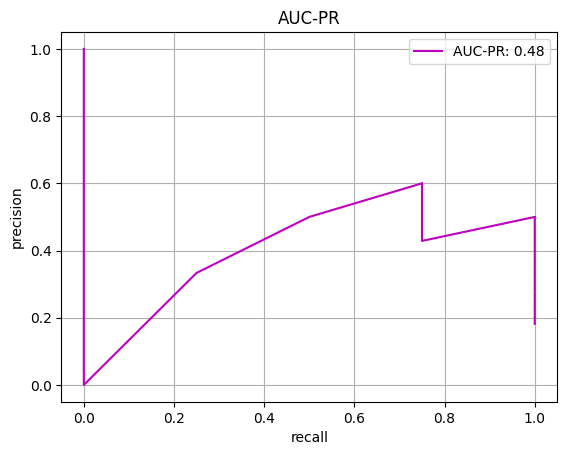

/tmp/ipython-input-1663762327.py:599: MatplotlibDeprecationWarning: The LOAD_NO_HINTING attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use LoadFlags.NO_HINTING instead.
  fig .savefig(path+"GNN-pipeline AUC-PR for PPI Inhibitors.pdf", bbox_inches='tight')
/tmp/ipython-input-1663762327.py:599: MatplotlibDeprecationWarning: The mode parameter as int was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use Kerning enum values instead.
  fig .savefig(path+"GNN-pipeline AUC-PR for PPI Inhibitors.pdf", bbox_inches='tight')


AucROC and aucpr Over all complexes 
 0.86 
 0.48 
total P:N ration 1: 0


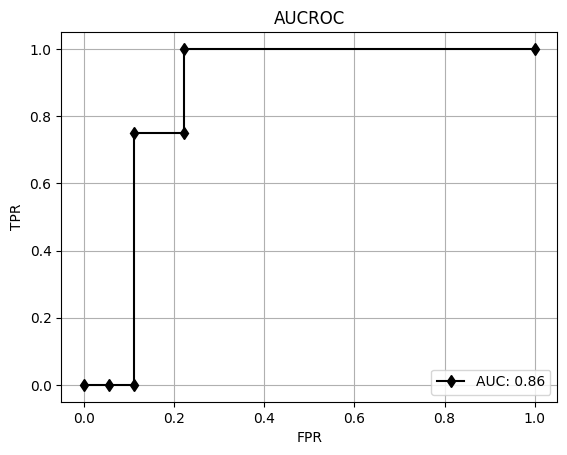

/tmp/ipython-input-1663762327.py:607: MatplotlibDeprecationWarning: The LOAD_NO_HINTING attribute was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use LoadFlags.NO_HINTING instead.
  fig .savefig(path+"GNN-pipeline AUCROC for vPPI Inhibitors.pdf", bbox_inches='tight')
/tmp/ipython-input-1663762327.py:607: MatplotlibDeprecationWarning: The mode parameter as int was deprecated in Matplotlib 3.10 and will be removed in 3.12. Use Kerning enum values instead.
  fig .savefig(path+"GNN-pipeline AUCROC for vPPI Inhibitors.pdf", bbox_inches='tight')


NameError: name 'p' is not defined

In [37]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan  9 13:06:21 2024

@author: u1876024
"""

import warnings
from Bio.PDB import *
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pdb
import warnings
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import glob
from Bio.PDB import *
import warnings
from Bio.PDB import *
import numpy as np
from Bio.PDB.NeighborSearch import NeighborSearch
from tqdm import tqdm as tqdm
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
import pandas as pd
import random
from sklearn.metrics import auc,precision_recall_curve
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score
import pickle
from rdkit import Chem
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
USE_CUDA = torch.cuda.is_available()
from torch.autograd import Variable
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

'''
Using Sklearn One hot encoder to encode the atoms
Output is of size N*M where N is the total number of atoms and M is the total number of encoded features
'''
def atom1(structure):
    atomslist=np.array(sorted(np.array(['C', 'CA', 'CB', 'CG', 'CH2', 'N','NH2',  'OG','OH', 'O1', 'O2', 'SE','1']))).reshape(-1,1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(atomslist)
    atom_list=[]
    for atom in structure.get_atoms():
        if atom.get_name() in atomslist:
            atom_list.append(atom.get_name())
        else:
            atom_list.append("1")
    atoms_onehot=enc.transform(np.array(atom_list).reshape(-1,1)).toarray()
    return atoms_onehot
##############
'''
One hot encoded residue infomration using SKlearn Library

Output is N*M where N is the total number of atoms and M is the encoded features of the residues.
Any unknown  residue is mapped to 1
'''


def res1(structure):
    residuelist=np.array(sorted(np.array(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL', 'CYS', 'HIS','1']))).reshape(-1,1)
    encr = OneHotEncoder(handle_unknown='ignore')
    encr.fit(residuelist)
    residue_list=[]
    for atom in structure.get_atoms():
        if atom.get_parent().get_resname() in residuelist:
            residue_list.append((atom.get_parent()).get_resname())
        else:
            residue_list.append("1")

    res_onehot=encr.transform(np.array(residue_list).reshape(-1,1)).toarray()

    return res_onehot
###########

'''
It calculates the neighbours of each atom i.e. 10 distinct neighbours
Output is  in the form of a ditionary representing an  adjacency list where each source atom and neighbouring atom is represented bby its sequence index .
'''


def neigh1(structure):
    #atom_list is a numpy array  that   contains all the atoms of the pdb file in atom object
    atom_list=np.array([atom for atom in structure.get_atoms()])

    #for atom in structure.get_atoms():
    #    atom_list.append(atom)
    #neighbour_list contains all the  neighbour atomic pairs  i.e. like if N has neighbours O and C then it is stored as [[N,C],[N,O]] i.e. has dimension N*2 where N is the total number of possible neighbours all the atoms have in an unsorted manner and it stores in the form of  atom object


    p4=NeighborSearch(atom_list)
    neighbour_list=p4.search_all(6,level="A")
    neighbour_list=np.array(neighbour_list)

    #dist is the distance between the neighbour and the source atom  i.e. dimension is N*1
    dist=np.array(neighbour_list[:,0]-neighbour_list[:,1])
    #sorting in ascending order
    place=np.argsort(dist)
    sorted_neighbour_list=neighbour_list[place]

    #old_atom_number is used for  storing atom id of the original protein before sorting
    #old_residue_number is used for storing residue number of the original protein before sorting
    source_vertex_list_atom_object=np.array(sorted_neighbour_list[:,0])
    len_source_vertex=len(source_vertex_list_atom_object)
    neighbour_vertex_with_respect_each_source_atom_object=np.array(sorted_neighbour_list[:,1])
    old_atom_number=[]
    old_residue_number=[]
    for i in atom_list:
        old_atom_number.append(i.get_serial_number())
        old_residue_number.append(i.get_parent().get_id()[1])
    old_atom_number=np.array(old_atom_number)
    old_residue_number=np.array(old_residue_number)
    req_no=len(neighbour_list)
    total_atoms=len(atom_list)
    #neigh_same_res is the 2D numpy array to store the indices of the  neighbours of  same residue and is of the shape N*10 where N is the total number of atoms
    #neigh_diff_res is 2D numpy array to store  the indices of the  neighbours of different residue
    #same_flag is used to restrict the neighbours belonging to same residue  to 10
    #diff_flag is used to restrict the neighbours belonging to different residue to 10
    neigh_same_res=np.array([[-1]*10 for i in range(total_atoms)])
    neigh_diff_res=np.array([[-1]*10 for i in range(total_atoms)])
    same_flag=[0]*total_atoms
    diff_flag=[0]*total_atoms
    for i in range(len_source_vertex):
        source_atom_id=source_vertex_list_atom_object[i].get_serial_number()
        neigh_atom_id=neighbour_vertex_with_respect_each_source_atom_object[i].get_serial_number()
        source_atom_res=source_vertex_list_atom_object[i].get_parent().get_id()[1]
        neigh_atom_res=neighbour_vertex_with_respect_each_source_atom_object[i].get_parent().get_id()[1]
        #finding out index of the source and neighbouring atoms from the original atom array with respect to their residue id and atom id
        temp_index1=np.where(source_atom_id==old_atom_number)[0]

        temp_index2=np.where(neigh_atom_id==old_atom_number)[0]
        for i1 in temp_index1:
            if old_residue_number[i1]==source_atom_res:
                source_index=i1
                break
        for i1 in temp_index2:
            if old_residue_number[i1]==neigh_atom_res:
                neigh_index=i1
                break
        #if both the residues are same

        if source_atom_res==neigh_atom_res :

            #limiting the number of neighbours of same residue to 10

            if int(same_flag[source_index])< 10:
                neigh_same_res[source_index][same_flag[source_index]]=neigh_index
                same_flag[source_index]+=1

            if int(same_flag[neigh_index])< 10:
                neigh_same_res[neigh_index][same_flag[neigh_index]]=source_index
                same_flag[neigh_index]+=1

        # if both the residues are different
        elif source_atom_res!=neigh_atom_res :

            #limiting the number of neighbours of different residues to 10

            if int(diff_flag[source_index])< 10:
                neigh_diff_res[source_index][diff_flag[source_index]]=neigh_index
                diff_flag[source_index]+=1


            if int(diff_flag[neigh_index])< 10:

                neigh_diff_res[neigh_index][diff_flag[neigh_index]]=source_index
                diff_flag[neigh_index]+=1




    return neigh_same_res,neigh_diff_res


if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")
class GNN_Layer(nn.Module):

    def __init__(self, filters, v_feats, trainable=True, **kwargs):
        #pdb.set_trace()
        super(GNN_Layer, self).__init__()
        self.v_feats = v_feats
        self.filters = filters

        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device=device
        self.Wsv = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr = nn.Parameter( torch.randn(self.v_feats, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10
        #print("Wsv shape",self.Wsv.shape)

    def forward(self, x):
        #pdb.set_trace()
        Z,same_neigh,diff_neigh = x
        node_signals = Z@self.Wsv
        neigh_signals_same=Z@self.Wsr
        neigh_signals_diff=Z@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)

        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal = (torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal = (torch.sum(diff_neigh_features, axis=1))/diff_norm
        final_res = torch.relu(node_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res,same_neigh,diff_neigh

class GNN_First_Layer(nn.Module):

    def __init__(self, filters, trainable=True, **kwargs):

        super(GNN_First_Layer, self).__init__()
        self.filters = filters
        #pdb.set_trace()
        self.trainable = trainable
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device
        self.Wv = nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wr = nn.Parameter( torch.randn(21,self.filters, device=self.cuda_device,requires_grad=True))
        self.Wsr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.Wdr= nn.Parameter( torch.randn(13, self.filters, device=self.cuda_device,requires_grad=True))
        self.neighbours=10


    def forward(self, x):
        atoms, residues,same_neigh,diff_neigh = x
        node_signals = atoms@self.Wv
        residue_signals = residues@self.Wr
        neigh_signals_same=atoms@self.Wsr
        neigh_signals_diff=atoms@self.Wdr
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(2)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(2)
        """
        unsqueezed_same_neigh_indicator=(same_neigh>-1).unsqueeze(1)
        unsqueezed_diff_neigh_indicator=(diff_neigh>-1).unsqueeze(1)
        """
        same_neigh_features=neigh_signals_same[same_neigh]*unsqueezed_same_neigh_indicator
        diff_neigh_features=neigh_signals_diff[diff_neigh]*unsqueezed_diff_neigh_indicator
        #print("same norm",same_neigh > -1, 1)
        same_norm = torch.sum(same_neigh > -1, 1).unsqueeze(1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1, 1).unsqueeze(1).type(torch.float)
        same_norm = torch.sum(same_neigh > -1).type(torch.float)
        diff_norm = torch.sum(diff_neigh > -1).type(torch.float)
        # To prevent divide by zero error
        same_norm[same_norm==0]=1
        diff_norm[diff_norm==0]=1
        neigh_same_atoms_signal=(torch.sum(same_neigh_features, axis=1))/same_norm
        neigh_diff_atoms_signal=(torch.sum(diff_neigh_features, axis=1))/diff_norm

        final_res = torch.relu(node_signals+residue_signals +neigh_same_atoms_signal+neigh_diff_atoms_signal)

        return final_res, same_neigh,diff_neigh


class Dense(nn.Module):
    def __init__(self, in_dims, out_dims, trainable=True, **kwargs):
        #pdb.set_trace()
        super(Dense, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        self.cuda_device = device

        self.W = nn.Parameter( torch.randn(self.in_dims, self.out_dims, device=self.cuda_device,requires_grad=True))

    def forward(self, x):
        #pdb.set_trace()
        Z = torch.sigmoid(torch.matmul(x, self.W))

        return Z

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GNN_First_Layer(filters=512)
        self.conv2 = GNN_Layer(v_feats=512, filters=1024)
        self.conv3 = GNN_Layer(v_feats=1024, filters=512)
        self.dense = Dense(in_dims=512, out_dims=1)
    def forward(self, x):
        x1=self.conv1(x)
        x2=self.conv2(x1)
        x3=self.conv3(x2)
        x=x3[0]
        x=torch.sum(x,axis=0).view(1,-1)
        x = F.normalize(x)
        return x

    def processProtein(UniqueProtein, PdBloc):#, PdBloc):
        data_list = []

        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda:0" if use_cuda else "cpu")
        PData_dict={}
        for i in range(len(UniqueProtein)):
            #print('Converting PDB to Graph: {}/{}'.format(i+1, len(UniqueProtein)))
            UniqueProtein[i]=UniqueProtein[i].split('.pdb')[0]
            P1=PdBloc+UniqueProtein[i]+'.pdb'
            #if P1 in UniqueProtein:
            parser = PDBParser()
            with warnings.catch_warnings(record=True) as w:
              structure = parser.get_structure("", P1)
            one_hot_atom=(atom1(structure))

            one_hot_res=(res1(structure))
            neigh_same_res,neigh_diff_res=(neigh1(structure))
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            one_hot_atom=torch.tensor(one_hot_atom,dtype=torch.float32).to(device)
            one_hot_res=torch.tensor(one_hot_res,dtype=torch.float32).to(device)
            neigh_same_res=torch.tensor(neigh_same_res).to(device).long()
            neigh_diff_res=torch.tensor(neigh_diff_res).to(device).long()
            GNNData = [one_hot_atom,one_hot_res,neigh_same_res,neigh_diff_res]
            PData_dict[UniqueProtein[i]]= GNNData
        return PData_dict
def readFile(filename):
  with open(filename) as f:
    D = f.readlines()
  Name=[];PdbId=[];Ligandnames=[];SMILES=[];labels=[];
  All_data_list=[]
  from tqdm import tqdm as tqdm
  #2XA0_A_2_B 2O21 2XA0 43B c1ccc(cc1)CCc2nc3cc(ccc3s2)c4ccc(cc4)C(=O)NS(=O)(=O)c5ccc(c(c5)[N](=O)[O-])NCCSc6ccccc6  1
  for d in tqdm(D):
      #if len(d)==6:
      name,inhibtedc,Pdbid,Ligandid,smiles,y = d.split()
      Name.append(name);PdbId.append(Pdbid);Ligandnames.append(Ligandid);SMILES.append(smiles);labels.append(float (y));
  return  PdbId,Ligandnames,SMILES,labels
class IPPI_MLP_Net(nn.Module):
    def __init__(self):
        super(IPPI_MLP_Net, self).__init__()
        self.fc1 = nn.Linear(2840, 1024)#4096)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)
        self.fc6 = nn.Linear(100, 1)
    def forward(self, PFeatures,LigandFeatures,ProteinInterfaceF):
          Cfeatures=LigandFeatures
          P_all_Features=torch.hstack((PFeatures,ProteinInterfaceF))
          PC_Features=torch.hstack((P_all_Features,Cfeatures))
          x = torch.tanh(self.fc1(PC_Features))
          x = torch.tanh(self.fc2(x))
          x = torch.relu(self.fc3(x))
          x = self.fc6(x)
          return x

#path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
"""
path = location of pkl files from these links:
https://drive.google.com/file/d/1goeDiPZSKT1Xx3j00eNG9xlqYkLLv1gW/view
https://drive.google.com/file/d/1GOYEKLQCoGea9QQ72kujy0rdJKbUSYAE/view

githubpath =  location of the directory containing the github repo PPI-Inhibitors
obtained using
git clone https://github.com/adibayaseen/PPI-Inhibitors
"""
Ubench5InterfaceandSeq_dict=pickle.load(open(githubpath+'Features/NewUbench5InterfaceandSeq_dict.npy',"rb"))
Pos_seqandInterfaceF_dict=pickle.load(open(githubpath+'Features/Pos_seqandInterfaceF_dict.npy',"rb"))
Complex_AllFeatures_dict=dict( list (Pos_seqandInterfaceF_dict.items())+list (Ubench5InterfaceandSeq_dict.items()))
##############
ComplexInterfaceFeatures={}
for key in Complex_AllFeatures_dict:
  if len(key.split('_'))>1:
    compname=key.split('_')[0]
    ComplexInterfaceFeatures[compname]=Complex_AllFeatures_dict[key]#.cuda()
  else:
    ComplexInterfaceFeatures[key]=Complex_AllFeatures_dict[key]#.cuda()
CompoundFingerprintFeaturesDict=pickle.load(open(githubpath+'Features/Compound_Fingerprint_Features_Dict.npy',"rb"))
#Load Protein data for GNN
path='/content/drive/MyDrive/GNN-PPI-Inhibitor/'
ProteinDataGNN_dict=pickle.load(open(path+'ProteinData_dict.pickle',"rb"))
DBD5_ProteinDataGNN_dict=pickle.load(open(path+'DBD5_ProteinData_dict.pickle',"rb"))
All_ProteinData_dict=dict( list (ProteinDataGNN_dict.items())+list (DBD5_ProteinDataGNN_dict.items()))
for d in All_ProteinData_dict:
  data=All_ProteinData_dict[d]
  All_ProteinData_dict[d]=[data[0].cuda(),data[1].cuda(),data[2].cuda(),data[3].cuda()]
#########
with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN_Binary.txt') as f:
#with open(githubpath+'Data/WriteAllexamplesRandomBindersIdsAll_24JAN.txt') as f:
    D = f.readlines()
Labels=[];Ligandnames=[];Complexs=[];TestPoscomplexes=[];#SMILESlist=[];
for d in tqdm(D):
  if len(d.split())==4:
      TestPoscomp,Complexname,Ligandname,label = d.split()
  else:
      TestPoscomp,Complexname,Ligandname,label = d.split()[0],d.split()[1],(' ').join(d.split()[2:-1]),d.split()[-1]
  TestPoscomplexes.append(TestPoscomp),Ligandnames.append(Ligandname);Complexs.append(Complexname);Labels.append(float (label))
#########Make dictionary, Rootcomplexname=(complexname,compoundname),label
Allexamples=dict (zip(zip(TestPoscomplexes,zip(Complexs,Ligandnames)),Labels))
#Group kfold
Alldata=list (Allexamples.keys())
KK=[k[0].split('_')[0] for k in Alldata]
groups = pd.DataFrame(KK)
gkf = GroupKFold(n_splits=len(set (KK)))
###########
AUC_ROC_final=[];Avg_P_final=[];Z=[];Yo=[];Y_t=[];Y_score=[];
from os import listdir
AlltestExamples=[];Externallabels=[];ExternalscoresLOCO=[];covid19_Externallabels=[];covid19_ExternalscoresLOCO=[];Y_score=[];Y_t=[];classratio_dict={};
AUC_ROC_final=[];Avg_P_final=[];
Complexs,Ligandnames, Labels=np.array(Complexs),np.array(Ligandnames),np.array(Labels)
Alldata=np.array(Alldata, dtype=object)
classratio_dict=pickle.load(open(githubpath+'Features/Classratio_GNNdict.npy','rb'))

#%% Cross-validation
Done=set(KK).difference(['3D9T','1BKD','4ESG','2FLU','1YCQ','2XA0','3TDU','3D9T','2B4J','3DAB','3UVW','2RNY','4AJY', '1F47','1YCR','4QC3','1NW9','2E3K','4YY6','4GQ6','3WN7','1BXL','1Z92'])
for trainindex, testindex in gkf.split(KK, KK, groups=groups):
    train,test=Alldata[trainindex],Alldata[testindex]

    if test[0][0].split('_')[0] in Done:
      continue

    Ctr=[];Ptr=[];y_train=[];Ctrname=[];Ptrname=[];Xtr=[];G=[];Cttname=[];Ctt=[];y_test=[];Ptt=[];Pttname=[];
    #Split train and test
    for t in train:
        Ctrname.append(t[1][1]);Ctr.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        #change this only for GNN Complex_AllFeatures_dict with All_ProteinData_dic and t
        #####
        GNNcomp=t[1][0].split('_')[0]#t[1][0].split('_')[0]
        Ptrname.append(GNNcomp);Ptr.append(ComplexInterfaceFeatures[GNNcomp]);
        y_train.append(Allexamples[t[0],t[1]])
    #Split train and test
    for t in test:
        GNNcomp=t[1][0].split('_')[0]
        Cttname.append(t[1][1]);Ctt.append(CompoundFingerprintFeaturesDict[t[1][1]]);
        Pttname.append(GNNcomp);Ptt.append(ComplexInterfaceFeatures[GNNcomp]);
        y_test.append(Allexamples[t[0],t[1]])
    #standarization
    Pscaler = StandardScaler().fit(Ptr)
    Cscaler = StandardScaler().fit(Ctr)
    Ctr = Cscaler.transform(Ctr)
    Ptr=Pscaler.transform(Ptr)
    Ptt=Pscaler.transform(Ptt)
    Ptrdict=dict (zip(Ptrname,torch.FloatTensor(Ptr).cuda()))
    Ctrdict=dict (zip (Ctrname,torch.FloatTensor( Ctr).cuda()))
    Ctt = Cscaler.transform(Ctt)
    Cttdict=dict (zip (Cttname,torch.FloatTensor( Ctt).cuda()))
    Pttdict=dict (zip(Pttname,torch.FloatTensor(Ptt).cuda()))

    y_train = np.array(y_train)

    IPPI_Net = IPPI_MLP_Net().cuda()

    GNN_model=GNN().cuda()
    Mcomplexname=test[0][0].split('_')[0]
    criterion  = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(list (IPPI_Net.parameters()) + list( GNN_model.parameters()),lr=0.001,weight_decay=0.0)#001)#0.69 for 1mer single layer#, weight_decay=0.01, betas=(0.9, 0.999))

    bsize = 1024



    dataset = CustomDataset(train[:,1], y_train.astype('int'))
    batch_sampler = BinaryBalancedSampler(y_train.astype('int'), bsize)
    loader = DataLoader(dataset, batch_sampler=batch_sampler) # data loader that selects equal number of positive and negative examples

    test_dataset = CustomDataset(test[:,1], np.array(y_test).astype('int'))
    test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False)


    #y_train=torch.FloatTensor( y_train).cuda()
    ####
    print ("test complex ", Mcomplexname)

    Loss = [] #save loss values for plotting
    E = [] #save examples
    L = [] #save labels
    terminated = False
    best_result = 0.0
    best_model = None
    counter = 0
    early_stop_count = 0
    Zlist,Ylist=[],[]
    for iters in tqdm(range(5)):
        for (batch_pids,batch_cids),batch_labels in tqdm(loader):
            GNN_model.train()
            IPPI_Net.train()
            E.extend(zip(batch_pids,batch_cids))
            L.append(batch_labels)
            pids = [p.split('_')[0] for p in batch_pids]
            G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
            GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
            del G_dict #clear up memory
            interface_features = torch.vstack([Ptrdict[p] for p in pids])
            compound_features = torch.vstack([Ctrdict[c] for c in batch_cids])
            #[GNN_model(All_ProteinData_dict[p]) for p in set_pids]
            output = IPPI_Net(GNN_features,compound_features,interface_features)
            V = np.min(list(classratio_dict.values()))
            weights = toTensor(np.array([classratio_dict[p]/V if batch_labels[i]==1 else 1.0 for i,p in enumerate(pids)  ]))
            criterion  = nn.BCEWithLogitsLoss(weight = None)
            loss = criterion(output.flatten(), batch_labels.float().cuda())
            Loss.append(loss.item())
            #if np.median(Loss[-10:])<1e-1: terminated = True
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            early_stop_count += 1
            #%% Validation/Testing (saves the best model in every 10 iterations over the validation set)
            GNN_model.eval()
            IPPI_Net.eval()
            Z, Y = [], []
            with torch.no_grad():
                for (batch_pids,batch_cids),batch_labels in test_loader:
                    pids = [p.split('_')[0] for p in batch_pids]
                    G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
                    GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
                    del G_dict #clear up memory
                    interface_features = torch.vstack([Pttdict[p] for p in pids])
                    compound_features = torch.vstack([Cttdict[c] for c in batch_cids])
                    output = IPPI_Net(GNN_features,compound_features,interface_features)
                    Z.extend(output.cpu().flatten().numpy())
                    Y.extend(batch_labels.cpu().flatten().numpy())
                aucroc = roc_auc_score(np.array(Y), np.array(Z))
                aucpr = average_precision_score(Y,Z)
                if aucroc>best_result:
                    early_stop_count = 0
                    best_result = aucroc
                    best_model = (GNN_model.state_dict(),IPPI_Net.state_dict())
                    IPPI_Net.load_state_dict(best_model[1])#path+'/newIPPI_Net_'+test[0][0].split('_')[0]+'_AUC_'+str (round (best_result,3)))#torch.load(path+'IPPI_Net_'+ Mcomplexname)[1])
                    GNN_model.load_state_dict(best_model[0])
                    GNN_model.eval()
                    IPPI_Net.eval()
                    Zb, Yb = [], []
                    for (batch_pids,batch_cids),batch_labels in test_loader:
                      pids = [p.split('_')[0] for p in batch_pids]
                      G_dict = {p:GNN_model(All_ProteinData_dict[p]) for p in set(pids)} #pass each unique complex through the GNN once
                      GNN_features = torch.vstack([G_dict[p] for p in pids]) #append to make examples
                      del G_dict #clear up memory
                      interface_features = torch.vstack([Pttdict[p] for p in pids])
                      compound_features = torch.vstack([Cttdict[c] for c in batch_cids])
                      bestmodeloutput=IPPI_Net(GNN_features,compound_features,interface_features)
                      #torch.save(Loss, path+'/Loss_'+test[0][0].split('_')[0])
                      Zb.extend(bestmodeloutput.cpu().flatten().numpy())
                      Yb.extend(batch_labels.cpu().flatten().numpy())
                    aucrocb = roc_auc_score(np.array(Yb), np.array(Zb))
                    aucprb = average_precision_score(Yb,Zb)
                    print('LOADED BEST AUCROC',aucrocb,'AUCPR',aucprb)#,'best aucroc')
                    aucpr = average_precision_score(Y,Z)
                    print('AUCROC',aucroc,'AUCPR',aucpr,'best aucroc',best_result)
    ###Load best model
    print ("OUTSIDE LOOP AUC of Best")
    torch.save(best_model[1], path+'/GNN-based-pipeline_IPPI_Net_'+ test[0][0].split('_')[0])
    torch.save(best_model[0], path+'/GNN-based-pipeline_GNN_model_'+ test[0][0].split('_')[0])
    Zlist.extend(Zb);Ylist.extend(Yb)
    np.save(path+test[0][0].split('_')[0]+'Scores',Zb)
    np.save(path+test[0][0].split('_')[0]+'Targets',Yb)
    aucrocb = roc_auc_score(np.array(Yb), np.array(Zb))
    aucprb = average_precision_score(Yb,Zb)
    print('Complex name',test[0][0].split('_')[0],'AUCROC',aucrocb,'AUCPR',aucprb)#,'best aucroc')
fpr, tpr, thresholds = roc_curve(Ylist, Zlist)
Auc = roc_auc_score(Ylist, Zlist)
Auc=(Auc).round(2)
# calculate precision-recall curve
Zlist=np.array(Zlist);Yo=np.array(Ylist);
#Y_t=np.array(Y_t);Y_score=np.array(Y_score)
precision, recall, thresholds = precision_recall_curve(Ylist, Zlist)
aucpr=average_precision_score (Ylist, Zlist)
########
np.save(path+'GNN-pipeline_Targets.npy',Ylist)
np.save(path+'GNN-pipeline_Scores.npy',Zlist)
######+
fig = plt.figure()
plt.plot(recall,precision,color='m',marker=',',label='AUC-PR:{: .2f}'.format(aucpr))
plt.title('AUC-PR');plt.xlabel('recall');plt.ylabel('precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GNN-pipeline AUC-PR for PPI Inhibitors.pdf", bbox_inches='tight')
###
aucpr=(aucpr).round(2)
print("AucROC and aucpr Over all complexes \n",Auc,"\n",aucpr,"\ntotal P:N ration 1:",int (np.sum([Yo==-1.0])/np.sum([Yo==1.0])))#,"\n")
#######
fig = plt.figure()
plt.plot(fpr,tpr,color='k',marker='d',label='AUC:{: .2f}'.format(Auc))
plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"GNN-pipeline AUCROC for vPPI Inhibitors.pdf", bbox_inches='tight')
###
print("Final average over all folds,Leave one complex out",np.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))

In [38]:
print("Final average over all folds,Leave one complex out",np.average(AUC_ROC_final).round(4),'±',np.std( AUC_ROC_final).round(4),np.average(Avg_P_final).round(4),'±',np.std( Avg_P_final).round(4))

Final average over all folds,Leave one complex out nan ± nan nan ± nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score,roc_curve,precision_score,recall_score,average_precision_score,precision_recall_curve,auc
import matplotlib.pyplot as plt
path,githubpath='/content/drive/MyDrive/GNN-PPI-Inhibitor/','/content/PPI-Inhibitors/'
Z_GearNet=np.load(path+'onlyGearnet_Scores.npy')
Yo_GearNet=np.load(path+'onlyGearnet_Targets.npy')
####
fpr_GearNet, tpr_GearNet, thresholds_GearNet = roc_curve(Yo_GearNet, Z_GearNet)
Auc_GearNet = roc_auc_score(Yo_GearNet, Z_GearNet)
Auc_GearNet=(Auc_GearNet).round(2)
# calculate precision-recall curve
precision_GearNet, recall_GearNet, thresholds = precision_recall_curve(Yo_GearNet, Z_GearNet)
aucpr_GearNet=auc(recall_GearNet,precision_GearNet)
aucpr_GearNet=(aucpr_GearNet).round(2)
#######
Yo_SVM=np.load(path+'All_SVM_Targets.npy')
Z_SVM=np.load(path+'All_SVM_Scores.npy')
####
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(Yo_SVM, Z_SVM)
Auc_SVM = roc_auc_score(Yo_SVM, Z_SVM)
Auc_SVM=(Auc_SVM).round(2)
# calculate precision-recall curve
precision_SVM, recall_SVM, thresholds = precision_recall_curve(Yo_SVM, Z_SVM)
aucpr_SVM=auc(recall_SVM,precision_SVM)
aucpr_SVM=(aucpr_SVM).round(2)
#####Change this
Yo_GNN=np.load(path+'GNN-pipeline_Targets.npy')
Z_GNN=np.load(path+'GNN-pipeline_Scores.npy')
##########
fpr_GNN, tpr_GNN, thresholds_GNN = roc_curve(Yo_GNN, Z_GNN)
Auc_GNN= roc_auc_score(Yo_GNN, Z_GNN)
Auc_GNN=(Auc_GNN).round(2)
# calculate precision-recall curve
precision_GNN, recall_GNN, thresholds = precision_recall_curve(Yo_GNN, Z_GNN)
aucpr_GNN=auc(recall_GNN,precision_GNN)
aucpr_GNN=(aucpr_GNN).round(2)
###### GNN LOCO average 0.8576 ± 0.0923 0.4366 ± 0.2003
##### SVM LOCO average 0.7445 ± 0.1958 0.3312 ± 0.2017
fig = plt.figure()
Auc_GNN_std,PR_GNN_std,Auc_SVM_std,PR_SVM_std=0.0923,0.01,0.16,0.18
Auc_GearNet_std,PR_GearNet_std=0.1,0.19
#text="There is an upcoming task in %d days at %d cluster!" %a %cluster
plt.plot(fpr_GNN,tpr_GNN,color='m',marker=',',markersize=2,label = ('GNN AUC-ROC : $ {} ± {}$').format(round(Auc_GNN,2), round(Auc_GNN_std,2)))
plt.plot(fpr_SVM,tpr_SVM,color='b',marker=',',markersize=2,label=('SVM AUC-ROC : $ {} ± {}$').format(round(Auc_SVM,2), round(Auc_SVM_std,2)))
plt.plot(fpr_GearNet,tpr_GearNet,color='k',marker='.', markersize=3,label=('GearNet AUC-ROC : $ {} ± {}$').format(round(Auc_GearNet,2),round(Auc_GearNet_std,2)))
plt.title('AUCROC');plt.xlabel('FPR');plt.ylabel('TPR');plt.grid();plt.legend();plt.show();
fig .savefig(path+"Comaprison of AUCROC SVM and GNN-base model PPI Inhibitors Random and Binders combine Negative.pdf", bbox_inches='tight')
#########
fig = plt.figure()
plt.plot(recall_GNN,precision_GNN,color='m',marker=',',markersize=2,label=('GNN AUC-PR : $ {} ± {}$').format(round(aucpr_GNN,2), round(PR_GNN_std,2)))
plt.plot(recall_SVM,precision_SVM,color='b',marker=',',markersize=2,label=('SVM AUC-PR: $ {} ± {}$').format(round(aucpr_SVM,2), round(PR_SVM_std,2)))
plt.plot(recall_GearNet,precision_GearNet,color='k',marker='.', markersize=3,label=('GearNet AUC-PR: $ {} ± {}$').format(round(aucpr_GearNet,2), round(PR_GearNet_std,2)))
plt.title('AUC-PR');plt.xlabel('Recall');plt.ylabel('Precision');plt.grid();plt.legend();plt.show();
fig .savefig(path+"Comaprison of AUC-PR SVM and GNN-base model PPI Inhibitors  Random and Binders combine.pdf", bbox_inches='tight')